In [ ]:
import operator
import random
from typing import Annotated, List, TypedDict

from IPython.display import Image, display
from langchain_core.messages import AIMessage, AnyMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.graph.message import add_messages

**Data Processing (Sequential)** 

In [ ]:
class State(TypedDict):
    """State holds the input and output values for processing."""

    input: int
    output: int

In [ ]:
def node_a(state: State) -> dict[str, int]:
    """Process the input state and return the output with a random offset.

    Args:
        state (State): The input state containing 'input' key.

    Returns:
        dict: A dictionary with the computed 'output' value.

    """
    input_value = state["input"]
    offset = random.randint(1, 10)
    output = input_value + offset
    print(f"NODE A:\n ->input:{input_value}\n ->offset:{offset}\n ->output:{output}\n ")
    return {"output": output}

In [ ]:
def node_b(state: State):
    input_value = state["output"]  # Coming from output
    offset = random.randint(1, 10)
    output = input_value + offset
    print(f"NODE B:\n ->input:{input_value}\n ->offset:{offset}\n ->output:{output}\n ")
    return {"output": output}

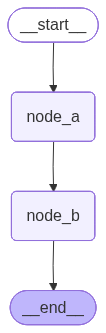

In [ ]:
workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke(
    input={
        "input": 1,
    },
)

NODE A:
 ->input:1
 ->offset:9
 ->output:10
 
NODE B:
 ->input:10
 ->offset:8
 ->output:18
 


{'input': 1, 'output': 18}

**Data Processing (Parallel)**

In [ ]:
class State(TypedDict):
    input: int
    output: int

In [ ]:
def node_a(state: State):
    input_value = state["input"]
    offset = random.randint(1, 10)
    output = input_value + offset
    print(f"NODE A:\n ->input:{input_value}\n ->offset:{offset}\n ->output:{output}\n ")
    return {"output": output}


def node_b(state: State):
    input_value = state["input"]  # Coming from input
    offset = random.randint(1, 10)
    output = input_value + offset
    print(f"NODE B:\n ->input:{input_value}\n ->offset:{offset}\n ->output:{output}\n ")
    return {"output": output}

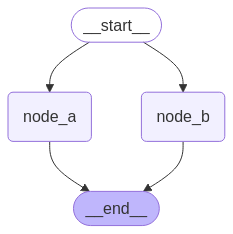

In [ ]:
workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge(START, "node_b")
workflow.add_edge("node_a", END)
workflow.add_edge("node_b", END)
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke(
    input={
        "input": 1,
    },
)

NODE A:
 ->input:1
 ->offset:5
 ->output:6
 
NODE B:
 ->input:6
 ->offset:1
 ->output:7
 


{'input': 1, 'output': 7}

**Data Processing with a Reducer**

In [ ]:
help(operator.add)

Help on built-in function add in module _operator:

add(a, b, /)
    Same as a + b.



In [ ]:
operator.add([1, 2, 3], [4, 5, 6])

[1, 2, 3, 4, 5, 6]

In [ ]:
class State(TypedDict):
    """State holds the input and output values for processing with a reducer.

    Attributes:
        input (int): The input value.
        output (Annotated[list[int], operator.add]): The output list of integers, annotated for reduction.

    """  # noqa: E501

    input: int
    output: Annotated[list[int], operator.add]

In [ ]:
def node_a(state: State) -> dict[str, list[int]]:
    """Process the input state and return the output as a list of integers.

    Args:
        state (State): The input state containing 'input' key.

    Returns:
        dict: A dictionary with the computed 'output' value as a list of ints.

    """
    input_value = state["input"]
    offset = random.randint(1, 10)  # noqa: S311
    output = input_value + offset
    print(f"NODE A:\n ->input:{input_value}\n ->offset:{offset}\n ->output:{output}\n ")
    return {"output": [output]}  # now it's a List of ints


def node_b(state: State) -> dict[str, list[int]]:
    """Process the input state and return the output as a list of integers.

    Args:
        state (State): The input state containing 'input' key.

    Returns:
        dict: A dictionary with the computed 'output' value as a list of ints.

    """
    input_value = state["input"]  # Coming from input
    offset = random.randint(1, 10)  # noqa: S311
    output = input_value + offset
    print(f"NODE B:\n ->input:{input_value}\n ->offset:{offset}\n ->output:{output}\n ")
    return {"output": [output]}  # now it's a List of ints

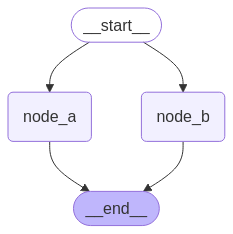

In [ ]:
workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge(START, "node_b")
workflow.add_edge("node_a", END)
workflow.add_edge("node_b", END)
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke(
    input={
        "input": 1,
    },
)

NODE A:
 ->input:1
 ->offset:8
 ->output:9
 
NODE B:
 ->input:1
 ->offset:3
 ->output:4
 


{'input': 1, 'output': [9, 4]}

**Call LLMs with Custom State and Langgraph operator**

In [ ]:
operator.add(
    [SystemMessage("You're a helpful assistant"), HumanMessage("Hi!")],
    [AIMessage("Hello! How can I assist you today?")],
)

[SystemMessage(content="You're a helpful assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={})]

In [ ]:
operator.add(
    [SystemMessage("You're a helpful assistant"), HumanMessage("Hi!")],
    AIMessage("Hello! How can I assist you today?"),
)

TypeError: can only concatenate list (not "AIMessage") to list

In [ ]:
help(add_messages)

Help on function _add_messages in module langgraph.graph.message:

_add_messages(
    left: 'Messages | None' = None,
    right: 'Messages | None' = None,
    **kwargs: 'Any'
) -> 'Messages | Callable[[Messages, Messages], Messages]'
    Merges two lists of messages, updating existing messages by ID.

    By default, this ensures the state is "append-only", unless the
    new message has the same ID as an existing message.

    Args:
        left: The base list of messages.
        right: The list of messages (or single message) to merge
            into the base list.
        format: The format to return messages in. If None then messages will be
            returned as is. If 'langchain-openai' then messages will be returned as
            BaseMessage objects with their contents formatted to match OpenAI message
            format, meaning contents can be string, 'text' blocks, or 'image_url' blocks
            and tool responses are returned as their own ToolMessages.

            !

In [ ]:
add_messages(
    left=[SystemMessage("You're a helpful assistant"), HumanMessage("Hi!")],
    right=AIMessage("Hello! How can I assist you today?"),
)

[SystemMessage(content="You're a helpful assistant", additional_kwargs={}, response_metadata={}, id='958ab47d-4690-45fd-8ab5-687799fee73a'),
 HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}, id='fdc7ba20-4599-4d73-a774-c3a1c3846385'),
 AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='ffe20276-70bb-4c11-9824-300c008c922e')]

In [ ]:
class State(TypedDict):
    """State holds the messages for processing with a reducer.

    Attributes:
        messages (Annotated[list[AnyMessage], add_messages]):
            The list of messages, annotated for reduction.

    """

    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
from dotenv import load_dotenv

load_dotenv()
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [ ]:
def model(state: State):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": response}

In [ ]:
workflow = StateGraph(State)
workflow.add_node("model", model)
workflow.add_edge(START, "model")
workflow.add_edge("model", END)
graph = workflow.compile()

In [ ]:
result = graph.invoke(
    input={"messages": [HumanMessage("What's the name of Ash's first pokémon?")]},
)

KeyError: 'messages'

In [ ]:
for message in result["messages"]:
    message.pretty_print()

NameError: name 'result' is not defined

**Call LLMs with Langgraph MessagesState**

In [ ]:
def model(state: MessagesState) -> dict:
    """Process the input state containing messages and return the response from the language model.

    Args:
        state (MessagesState): The input state containing 'messages' key.

    Returns:
        dict: A dictionary with the response messages.

    """
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": response}  # type: ignore  # noqa: PGH003

In [ ]:
workflow = StateGraph(MessagesState)
workflow.add_node("model", model)  # type: ignore  # noqa: PGH003
workflow.add_edge(START, "model")
workflow.add_edge("model", END)
graph = workflow.compile()  # type: ignore  # noqa: PGH003

In [ ]:
result = graph.invoke(  # pyright: ignore[reportUnknownMemberType]
    input={"messages": [HumanMessage("What's the name of Ash's first pokémon?")]},
)

In [23]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

What's the name of Ash's first pokémon?
================================== Ai Message ==================================

Ash's first Pokémon is Pikachu. He received Pikachu from Professor Oak at the beginning of his journey in the Pokémon anime series.
